## Final Project Submission

Please fill out:
* Student name: Mirriam Mumbua
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Anthony Muiko
* Blog post URL:


# BUSINESS UNDERSTANDING

## OBJECTIVE:
The primary objective of this project is to provide actionable insights for a new movie studio aiming to enter the competitive film industry. By analyzing diverse datasets from sources like Box Office Mojo, IMDB, Rotten Tomatoes, TheMovieDB, and The Numbers, we aim to identify key trends and factors that influence box office success. Our analysis will focus on uncovering what types of films—considering genre, release timing, and other factors—are most likely to perform well and generate substantial profits.


# DATA PREPARATION

## Data loading
we will be accesing the data and getting familiar with it

In [2]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
%matplotlib inline

In [3]:
import zipfile

# Unzip the SQLite database file
zip_path = './zippedData/im.db.zip'
extract_to = '.'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Connect to the SQLite database and query the tables
db_path = 'im.db'
conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
tables = cur.fetchall()

tables

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [4]:
#load box office data
bomdf=pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
bomdf.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


I am attempting to perform an API call to get the corresponding genre names of the genre ids in the following dataset

In [5]:
#Integrate API key
import requests
api_key='b91ed6a69c497497b60e2172b97b9833'

movies_genres_url = f'https://api.themoviedb.org/3/genre/movie/list?api_key={api_key}&language=en-US'
tv_genres_url = f'https://api.themoviedb.org/3/genre/tv/list?api_key={api_key}&language=en-US'

# Fetch movie genre data
response_movies_genres = requests.get(movies_genres_url)
if response_movies_genres.status_code == 200:
    movies_genres_data = response_movies_genres.json()
    movies_genres = movies_genres_data.get('genres', [])
    df_movies_genres = pd.DataFrame(movies_genres)
    movies_genre_mapping = dict(zip(df_movies_genres['id'], df_movies_genres['name']))
else:
    print(f"Failed to retrieve movie genres: {response_movies_genres.status_code}")
    movies_genre_mapping = {}

# Fetch TV show genre data
response_tv_genres = requests.get(tv_genres_url)
if response_tv_genres.status_code == 200:
    tv_genres_data = response_tv_genres.json()
    tv_genres = tv_genres_data.get('genres', [])
    df_tv_genres = pd.DataFrame(tv_genres)
    tv_genre_mapping = dict(zip(df_tv_genres['id'], df_tv_genres['name']))
else:
    print(f"Failed to retrieve TV genres: {response_tv_genres.status_code}")
    tv_genre_mapping = {}
print("Movie Genre Mapping:", movies_genre_mapping)
print("TV Genre Mapping:", tv_genre_mapping)


Movie Genre Mapping: {28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}
TV Genre Mapping: {10759: 'Action & Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 10762: 'Kids', 9648: 'Mystery', 10763: 'News', 10764: 'Reality', 10765: 'Sci-Fi & Fantasy', 10766: 'Soap', 10767: 'Talk', 10768: 'War & Politics', 37: 'Western'}


The API fetch works great.

In [6]:
#load tmdb data
tmdbdf=pd.read_csv('./zippedData/tmdb.movies.csv.gz')

Joining the movies and tv shows since the arrays might contain both

In [7]:
# Combine movie and TV genre mappings
from collections import ChainMap

combined_genre_mapping = dict(ChainMap(movies_genre_mapping, tv_genre_mapping))


print("Combined Genre Mapping:", combined_genre_mapping)


Combined Genre Mapping: {10759: 'Action & Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 10762: 'Kids', 9648: 'Mystery', 10763: 'News', 10764: 'Reality', 10765: 'Sci-Fi & Fantasy', 10766: 'Soap', 10767: 'Talk', 10768: 'War & Politics', 37: 'Western', 28: 'Action', 12: 'Adventure', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War'}


In [8]:
# Function to map genre IDs to names
def map_genre_ids_to_names(genre_ids, genre_mapping):
    return [genre_mapping.get(genre_id, 'Unknown') for genre_id in genre_ids]

# Apply the mapping function
tmdbdf['genre_names'] = tmdbdf['genre_ids'].apply(lambda ids: map_genre_ids_to_names(ids,combined_genre_mapping))
tmdbdf.head(15)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genre_names
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
5,5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
6,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
7,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
8,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."
9,9,"[16, 28, 35, 10751, 878]",38055,en,Megamind,22.855,2010-11-04,Megamind,6.8,3635,"[Unknown, Unknown, Unknown, Unknown, Unknown, ..."


In [9]:

#clean the data
#remove duplicates
tmdbdf=tmdbdf.drop_duplicates(subset='id')

#remove the punctuations in the titles
tmdbdf['title'] = tmdbdf['title'].str.replace(f'[{string.punctuation}]', '', regex=True)

#get the release months
tmdbdf['month'] = pd.to_datetime(tmdbdf['release_date']).dt.month

#drop unnecessary columns
tmdbdf=tmdbdf.drop(columns=['release_date', 'original_title'])


tmdbdf.head(15)

,Unnamed: 0,genre_ids,id,original_language,popularity,title,vote_average,vote_count,genre_names,month
0,0,"[12, 14, 10751]",12444,en,33.533,Harry Potter and the Deathly Hallows Part 1,7.7,10788,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",11
1,1,"[14, 12, 16, 10751]",10191,en,28.734,How to Train Your Dragon,7.7,7610,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",3
2,2,"[12, 28, 878]",10138,en,28.515,Iron Man 2,6.8,12368,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",5
3,3,"[16, 35, 10751]",862,en,28.005,Toy Story,7.9,10174,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",11
4,4,"[28, 878, 12]",27205,en,27.920,Inception,8.3,22186,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",7
5,5,"[12, 14, 10751]",32657,en,26.691,Percy Jackson the Olympians The Lightning Thief,6.1,4229,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",2
6,6,"[28, 12, 14, 878]",19995,en,26.526,Avatar,7.4,18676,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",12
7,7,"[16, 10751, 35]",10193,en,24.445,Toy Story 3,7.7,8340,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",6
8,8,"[16, 10751, 35]",20352,en,23.673,Despicable Me,7.2,10057,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",7
9,9,"[16, 28, 35, 10751, 878]",38055,en,22.855,Megamind,6.8,3635,"[Unknown, Unknown, Unknown, Unknown, Unknown, ...",11


## The above values of unknown come from my trying to do an API call to get the corresponding genres names and failing epicly


In [10]:
df_movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)

# Load the movie_ratings table into a DataFrame
df_movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)


In [11]:
#cleaning movie_basics
#drop duplicates
df_movie_basics=df_movie_basics.drop_duplicates(subset='movie_id')

#drop irrelevant columns
df_movie_basics=df_movie_basics.drop(columns=['original_title','runtime_minutes'])
# Remove punctuation from 'primary title'
df_movie_basics['primary_title'] = df_movie_basics['primary_title'].str.replace(f'[{string.punctuation}]', '', regex=True)

df_movie_basics.head(15)

,movie_id,primary_title,start_year,genres
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,Drama
3,tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,2018,Comedy
6,tt0112502,Bigfoot,2017,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,2017,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,2012,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,2012,Biography


In [12]:
df_movie_ratings.head(15)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
5,tt1069246,6.2,326
6,tt1094666,7.0,1613
7,tt1130982,6.4,571
8,tt1156528,7.2,265
9,tt1161457,4.2,148


# so the only data we need is the one of tmdb, box office and tn.movie

In [13]:
tn_movie=pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
# Function to clean money columns
def clean_money_column(column):
    # Remove the dollar sign and commas, then convert to numeric
    return pd.to_numeric(column.str.replace('[\$,]', '', regex=True))

# Apply the function to the money columns
tn_movie['domestic_gross'] = clean_money_column(tn_movie['domestic_gross'])
tn_movie['worldwide_gross'] = clean_money_column(tn_movie['worldwide_gross'])
tn_movie['production_budget'] = clean_money_column(tn_movie['production_budget'])

# Calculate the total gross profit
tn_movie['total_gross_profit'] = (tn_movie['domestic_gross'] + tn_movie['worldwide_gross']) - tn_movie['production_budget']

#calculate the percentage profit
tn_movie['percentage_profit']=(tn_movie['total_gross_profit']/tn_movie['production_budget']) *100
#remove punctuations from names
tn_movie['movie'] = tn_movie['movie'].str.replace(f'[{string.punctuation}]', '', regex=True)

tn_movie.head()

<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Miry\AppData\Local\Temp\ipykernel_16336\3615281644.py:5: SyntaxWarning: invalid escape sequence '\$'
  return pd.to_numeric(column.str.replace('[\$,]', '', regex=True))


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross_profit,percentage_profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,732.200683
1,2,"May 20, 2011",Pirates of the Caribbean On Stranger Tides,410600000,241063875,1045663875,876127750,213.377435
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-157475300,-44.992943
3,4,"May 1, 2015",Avengers Age of Ultron,330600000,459005868,1403013963,1531419831,463.224389
4,5,"Dec 15, 2017",Star Wars Ep VIII The Last Jedi,317000000,620181382,1316721747,1619903129,511.010451


# we have to take the relevant columns from the various dataframes and put in one final dataframe that will be used to draw insights

In [14]:
#merging the dataframes foronly the relevant coolumns
merged_df = pd.merge(tn_movie[['movie','percentage_profit']], tmdbdf[['title','vote_average','month']], 
                     left_on='movie', right_on='title', how='inner')
merged_df.head()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              2240 non-null   object 
 1   percentage_profit  2240 non-null   float64
 2   title              2240 non-null   object 
 3   vote_average       2240 non-null   float64
 4   month              2240 non-null   int32  
dtypes: float64(2), int32(1), object(2)
memory usage: 78.9+ KB


In [15]:
merged_df2=pd.merge(bomdf[['title','year']],merged_df, on='title', how='inner')

merged_df2.head()
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1111 non-null   object 
 1   year               1111 non-null   int64  
 2   movie              1111 non-null   object 
 3   percentage_profit  1111 non-null   float64
 4   vote_average       1111 non-null   float64
 5   month              1111 non-null   int32  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 47.9+ KB


In [16]:
merged_df3=pd.merge(df_movie_basics[['primary_title','genres']],merged_df2, left_on='primary_title',
                                    right_on='title' ,how='inner')
#drop the rows with null values
merged_df3.isna().sum()
merged_df3=merged_df3.dropna(subset='genres')

#drop duplicates
merged_df3=merged_df3.drop_duplicates(subset='primary_title')

#drop duplicated column
merged_df3=merged_df3.drop(columns=['title','movie'])
merged_df3['genres'].head()

0    Adventure,Drama,Romance
1     Adventure,Comedy,Drama
2         Action,Crime,Drama
3    Action,Adventure,Sci-Fi
4         Action,Crime,Drama
Name: genres, dtype: object

# DATA ANALYSIS AND VISUALIZATIONS

## Average Percentage Profit by Genre

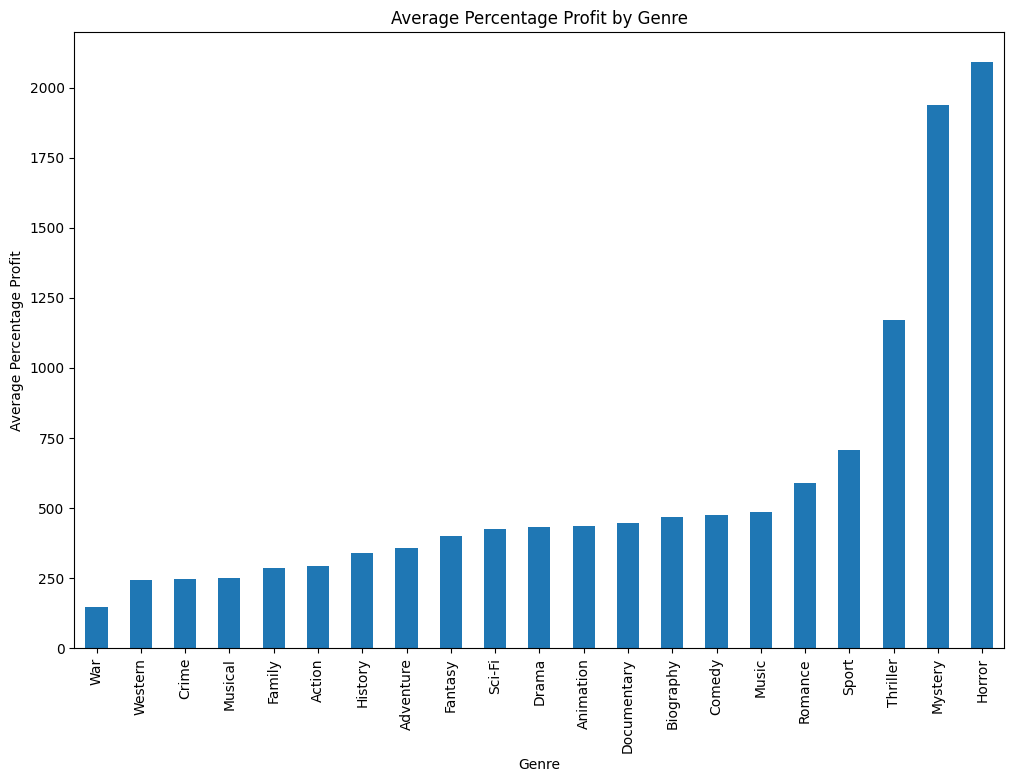

In [17]:
# Split genres into separate rows
genres_split = merged_df3.assign(genres=merged_df3['genres'].str.split(',')).explode('genres')

# Calculate average percentage profit by genre
average_profit_by_genre = genres_split.groupby('genres')['percentage_profit'].mean().sort_values()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
average_profit_by_genre.plot(kind='bar')
plt.title('Average Percentage Profit by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Percentage Profit')
plt.show()


It is evident that war genre has the least profit and horror has the most profit followed by Mystery

## Average Percentage Profit by Release Month

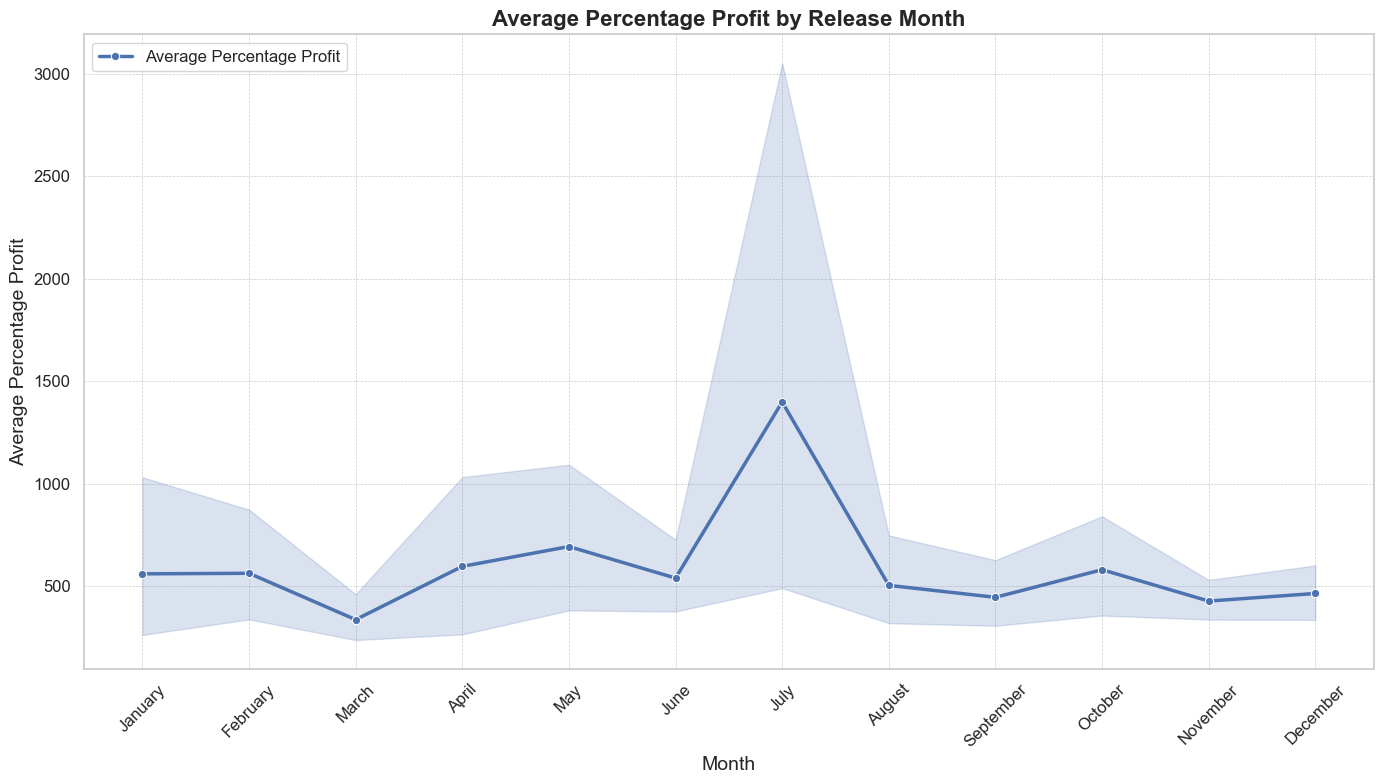

In [18]:
# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


# Create the line plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")  # Use a white grid background for better readability
sns.lineplot(x='month', y='percentage_profit', data=merged_df3, estimator=np.mean, marker='o', color='b', linewidth=2.5)

# Set the title and labels
plt.title('Average Percentage Profit by Release Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Percentage Profit', fontsize=14)

# Set the x-ticks to be the month names
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45, fontsize=12)

# Improve y-axis labels
plt.yticks(fontsize=12)

# Add grid for both x and y axes
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend
plt.legend(['Average Percentage Profit'], loc='upper left', fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


The beginning of july is the best time to release movies for maximum profit

## Correlation between Vote Average and Percentage Profit

Pearson correlation coefficient: -0.03
P-value: 3.00e-01


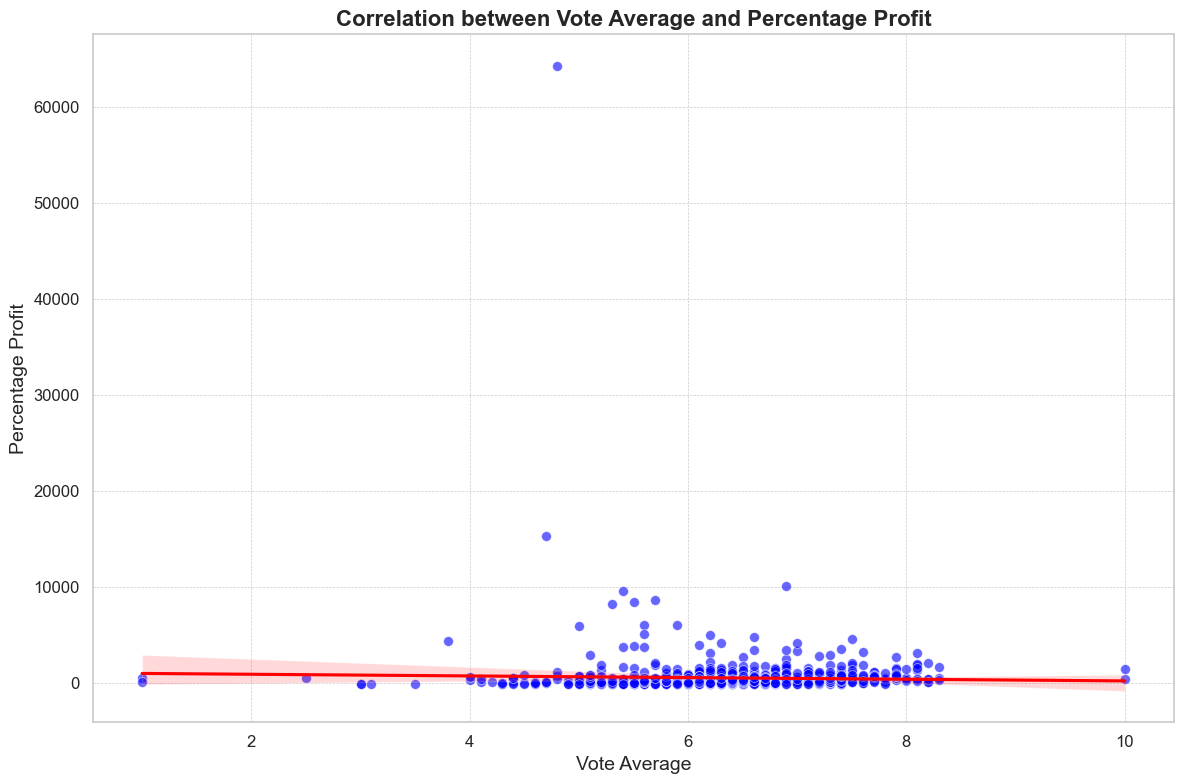

In [19]:
from scipy.stats import pearsonr

# Calculating Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(merged_df3['vote_average'], merged_df3['percentage_profit'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.2e}")

#scatter plot and regression line
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid") 
sns.scatterplot(x='vote_average', y='percentage_profit', data=merged_df3, color='blue', s=50, alpha=0.6)
sns.regplot(x='vote_average', y='percentage_profit', data=merged_df3, scatter=False, color='red')

plt.title('Correlation between Vote Average and Percentage Profit', fontsize=16, fontweight='bold')
plt.xlabel('Vote Average', fontsize=14)
plt.ylabel('Percentage Profit', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


Pearson Correlation Coefficient:A value of -0.03 suggests a very weak negative linear relationship between vote_average and percentage_profit.
A p-value of 0.30 is much higher than 0.05, indicating that the correlation is not statistically significant. This means that we do not have enough evidence to conclude that there is a meaningful linear relationship between vote_average and percentage_profit.

In [20]:
import statsmodels.api as sm

# Define the independent variables
X = merged_df3[['year', 'vote_average', 'month']]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Define the dependent variable
y = merged_df3['percentage_profit']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      percentage_profit   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6583
Date:                Sun, 28 Jul 2024   Prob (F-statistic):              0.578
Time:                        11:17:17   Log-Likelihood:                -9072.5
No. Observations:                 991   AIC:                         1.815e+04
Df Residuals:                     987   BIC:                         1.817e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.469e+04   5.89e+04     -0.928   